# Automatic Hyperparameter Tuning for a Classification Model

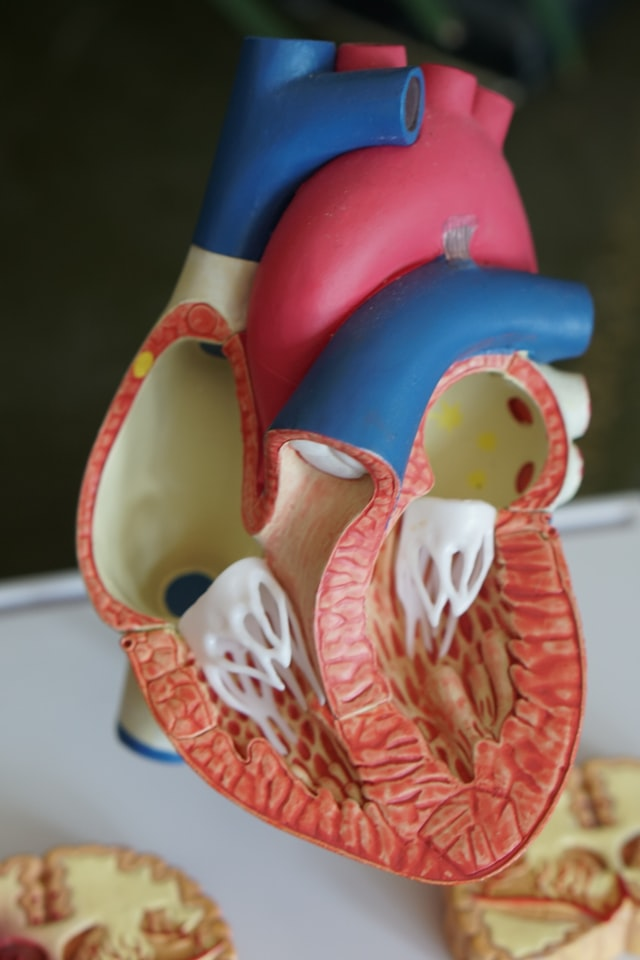
<span>Photo by <a href="https://unsplash.com/@averey?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Robina Weermeijer</a> on <a href="https://unsplash.com/s/photos/human-heart?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

There are many notebooks out there on Kaggle that aim to predict heart failure. This is but another one.  It's primary purpose is to demonstrate some of the automatic hyperparameter tuning capabilities of scikit-learn. In this notebok, I'll demonstrate how to use both GridSearchCV (slow, brute-force search through hyperparameter space) and BayesianSearchCV (an optimizer with the potential for accelerating hyperparameter tuning... at the expense of some accuracy loss) in order to perform hyperparameter optimization on various classifier algorithms, including a random forest, and a multiclass svm. 

Begin by importing all required libraries and then reading the heart failure data set into a pandas dataframe.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
 
df=pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

#df=df[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
#       'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'diabetes',
#       'high_blood_pressure','sex','smoking', 'DEATH_EVENT']]



Our classification models will be designed to predict whether a subject dies from heart failure or not. Before getting too deep into model building, we'll perform some perfunctory data preparation.  View the head fo the data frame.

In [ ]:
df.head()

The variables named *anaemia*, *diabetes*, *high_blood_pressure*, *sex*, and *smoking* all appear to be categorical / boolean. Shuffle the rows of the data frame and then move these categorical variables to the end of the other predictive variables for now. We'll probably ignore categorical predictors in this notebook when we begin building models.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df=df[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'diabetes',
      'high_blood_pressure','sex','smoking', 'DEATH_EVENT']]


Determine if there are missing values in the data.

In [ ]:
df.isna().values.any()

There are no missing values. We'll segregate our predictor variables from the response. 

In [ ]:
X=df.iloc[:,:-1]
y=df.DEATH_EVENT

Afterward, perform some elementary exploratory data analysis. Create a heatmap of the correlations between each feature in order to determine if there is a problem with column collinearity.

In [ ]:
X_corr=X.corr()
mask = np.zeros_like(X_corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X_corr, annot=True, fmt='.2f', mask=mask)
plt.show()

It appears that only sex and smoking have any real degree of dependence.  For now, we'll ignore this, but it's possible we'd want to eliminate one of these features later. We'll now split our data into training and testing sets and then move on to building models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Random Forest Classifier

We'll be searching through a parameterized family of random forest classifiers in order to find an optimal hyperparameter set in terms of classification accuracy. The param_grid dictionary establishes the ranges of hyperparameter values for the random forest classifier that we will be searching through. 

In [ ]:
param_grid = {'bootstrap': [True],
              'max_depth': np.arange(6,11,2),
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': np.arange(3,6,2),
              'min_samples_split': np.arange(4,7,2),
              'n_estimators': np.arange(100,351,20)
              }

Grid_SearchCV is the traditional, brute force method of searching through hyperparameter space for an optimally tuned model.  When we pass a RandomForestClassifier object and our param_grid dictionary to GridSearchCV, we create GridSearchCV object.  We'll in turn, create a pipeline that uses the StandardScaler transformer to standardize our training data before training a model from it and standardizes our testing data before making predictions. Finally, we invoke fit function of the pipeline in order to train each model in the hyperparameter grid and search for the optimal result. We'll time the training and hyperparameter search for comparison to another approach to hyperparameter optimization later.

In [ ]:
forest_search=GridSearchCV(RandomForestClassifier(),
                           param_grid,
                           cv=5,
                           verbose=True,
                           refit=True,
                           n_jobs=-1)

forest_clf = make_pipeline(StandardScaler(),forest_search)

import time
start = time.time()
forest_clf.fit(X_train,y_train)
end=time.time()

Report on the time it took to train the models and search for the optimal set of hyperparameter values. Then, report on the accuracy of the optimal model as well as the hyperparameter values it used.

In [ ]:
print("RF Fit Time:", end-start)
pred = forest_clf.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test))/len(pred)
print("RF Accuracy:", accuracy)
print("Forest Best Parameters:", forest_search.best_params_)


We've achieved good accuracy in a reasonable amount of time, but let's see if we can do better. Bayesian Optimation is an accelerated approach to hyperparamter optimization. It might not find the optimal set of hyperparameters, but it has the potential to get close in less time.

In [ ]:
forest_search=BayesSearchCV(RandomForestClassifier(),
                           param_grid,
                           cv=5,
                           verbose=True,
                           refit=True,
                           n_jobs=-1)

forest_clf = make_pipeline(StandardScaler(),forest_search)

import time
start = time.time()
forest_clf.fit(X_train,y_train)
end=time.time()

Report on the time it took to train the models and search for the optimal set of hyperparameter values. Then, report on the accuracy of the optimal model as well as the hyperparameter values it used.

In [ ]:
print("RF Fit Time:", end-start)
pred = forest_clf.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test))/len(pred)
print("RF Accuracy:", accuracy)
print("Forest Best Parameters:", forest_search.best_params_)

BayesSearchCV took about half the time as GridSearchCV and still achieved about 90% accuracy. Next, we'll see how well this works with other classification models.  

# Multiclass SVM with ensemble bagging

SVM classifiers often train slowly during hyperparameter optimization. We'll compare GridSearchCV to BayesSearchCV for a SVM classifier. First establish the hyperparameter set over which we'll optimize our classifier

In [ ]:

params = dict()
params['base_estimator__C'] = (1e-6, 100.0, 'log-uniform')
params['base_estimator__gamma'] = (1e-6, 100.0, 'log-uniform')
params['base_estimator__degree'] = (1,5)
params['base_estimator__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
params['n_estimators'] =(5,20)




We'll run a grid search. You might not want to actually run this block of code, however.  It takes a long time to run.

In [ ]:
svm_search= GridSearchCV(BaggingClassifier(base_estimator=SVC()),
                         param_grid=params,
                         cv=10,
                         verbose = True,
                         refit = True,
                         n_jobs=-1)
svm_clf = make_pipeline(StandardScaler(),svm_search)


start = time.time()
svm_clf.fit(X_train, y_train)
end = time.time()

print("SVM Fit Time:", end-start)
pred =  svm_clf.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test))/len(pred)
print("SVM Accuracy:", accuracy)
print("SVM Best Parameters:", svm_search.best_params_)

Now we'll perform Bayesian optimization in hopes of improving our training time.

In [ ]:
svm_search= BayesSearchCV(BaggingClassifier(base_estimator=SVC()),
                         search_spaces=params,
                         cv=10,
                         verbose = True,
                         refit = True,
                         n_jobs=-1)
svm_clf = make_pipeline(StandardScaler(),svm_search)


start = time.time()
svm_clf.fit(X_train, y_train)
end = time.time()

print("SVM Fit Time:", end-start)
pred =  svm_clf.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test))/len(pred)
print("SVM Accuracy:", accuracy)
print("SVM Best Parameters:", svm_search.best_params_)

At between 140 and 150 seconds compared to nearly 2000 seconds of fit time, Bayesian Optimization ran significantly faster than Grid search.  However, it did come with a modest reduction in accuracy.